# Bài toán phân loại sử dụng SVM 


Mục tiêu: 

- Xây dựng được mô hình svm sử dụng thư viện sklearn. 
- Ứng dụng, hiểu cách áp dụng mô hình svm vào giải quyết bài toán thực tế (vd: phân loại tin tức dạng văn bản) .
- Sử dụng độ đo Accuracy để làm độ đo đánh giá chất lượng mô hình. 

Vấn đề: 

- Có một tập các văn bản dạng text không có nhãn, làm sao để biết văn bản này là thuộc về thể loại nào, pháp luật, đời sống, văn học, thể thao ...
- Cần xây dựng mô hình học máy phân loại các thể loại của văn bản dựa trên nội dung.  

Dữ liệu: 

- Có tập các văn bản và nhãn tương ứng của từng văn bản trong một khoảng thời gian 
- Tập các nhãn - 10 nhãn văn bản: 
    > Giải trí, Khoa học - Công nghệ, Kinh tế, Pháp luật, Sức khỏe, Thể thao, Thời sự, Tin khác, Độc giả, Đời sống - Xã hội
- Ví dụ văn bản nhãn **thể thao**: 
    > "Dân_trí Real Madrid đã dẫn trước trong cả trận đấu , nhưng họ vẫn phải chấp_nhận bị Dortmund cầm hòa 2-2 ở Bernabeu . Real Madrid chấp_nhận đứng thứ_hai ở bảng F Champions League ..."

Bài toán: 

- Input: tập các từ trong văn bản 1 mẫu dữ liệu $X = [x_1, x_2, ... x_n]$
- Output: nhãn $y$ là 1 trong 10 nhãn trên 

### Tong quan ve cac buoc thuc hien:
#### Buoc 1
1. Tien xu ly van ban (Loai bo cac tu noi, dau cau khong can thiet)
2. Tach tu (Tokenization)
#### Buoc 2
Dem tan suat tu va danh trong so (Muc do quan trong)
#### Buoc 3:
Huan luyen mo hinh SVM
#### Buoc 4:
Du doan va danh gia


In [1]:
# Cài đặt thư viện xử lý ngôn ngữ cho tiếng Việt!
!pip install pyvi

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_files
from pyvi import ViTokenizer


from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

%matplotlib inline

## 1. Sử dụng sklearn.datasets.load_files để load dữ liệu từ thư mục đã down từ trước

Cấu trúc thư mục như sau 

- data/news_1135/

    - Kinh tế: 
        - bài báo 1.txt 
        - bài báo 2.txt 
    - Pháp luật
        - bài báo 3.txt 
        - bài báo 4.txt 

In [3]:
data_train = load_files(container_path="data/news_1135/", encoding="utf-8")

print(data_train.filenames)
print()

print("Tong so file: {}" .format( len(data_train.filenames)))
print("Danh sách nhãn và id tương ứng: ", [(idx, name) for idx, name in enumerate(data_train.target_names)] )


['data/news_1135/Pháp luật/0e7537e00a4dd4c8c1b8d786858885c920311800.txt'
 'data/news_1135/Thời sự/7ea376282b8acc4cb3784dbaa9fa995b52e57ce1.txt'
 'data/news_1135/Thể thao/e78ef641b159653587e011d5929935b33e78c8d8.txt'
 ...
 'data/news_1135/Tin kh†c/79a417e6e6db3325e0a9485fe4e7ed504f526ec7.txt'
 'data/news_1135/Thể thao/5ee1dd38f31f2c61aa851907eddbc3d84dbad1b4.txt'
 'data/news_1135/Thời sự/4d983a17cb022cdb89d9ddcdfe6475b32f4673e1.txt']

Tong so file: 1027
Danh sách nhãn và id tương ứng:  [(0, 'Giải trí'), (1, 'Khoa học - Công nghệ'), (2, 'Kinh tế'), (3, 'Pháp luật'), (4, 'Sức khỏe'), (5, 'Thể thao'), (6, 'Thời sự'), (7, 'Tin kh†c'), (8, 'Đời sống - Xã hội'), (9, 'Độc giả')]


###  Tiền xử lý dữ liệu đưa dữ liệu từ dạng text về dạng ma trận 

- Thử nghiệm để kiểm tra hoạt động chuyển hoá dữ liệu về dạng ma trận 

In [4]:
# load dữ liệu các stopwords 
with open("data/vietnamese-stopwords.txt",encoding="utf-8") as f:
    stopwords = f.readlines()
stopwords = [x.strip().replace(" ", "_") for x in stopwords] 
print("Danh sách 10 từ dừng đầu tiên (từ không mang ý nghĩa phân loại): ", stopwords[:10])

# Transforming data 
# Chuyển hoá dữ liệu text về dạng vector tfidf 
#     - loại bỏ từ dừng
#     - sinh từ điển
module_count_vector = CountVectorizer(stop_words=stopwords)
model_rf_preprocess = Pipeline([('vect', module_count_vector),
                    ('tfidf', TfidfTransformer()),
                    ])
# Hàm thực hiện chuyển đổi dữ liệu text thành dữ liệu số dạng ma trận 
# Input: Dữ liệu 2 chiều dạng numpy.array, mảng nhãn id dạng numpy.array 
data_preprocessed = model_rf_preprocess.fit_transform(data_train.data, data_train.target)
print("10 từ đầu tiên trong từ điển:")
i = 0
for k,v in module_count_vector.vocabulary_.items():
    i+=1
    print(i, ": ", (k, v))
    if i > 10:
        break 

Danh sách 10 từ dừng đầu tiên (từ không mang ý nghĩa phân loại):  ['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy', 'ai_đó', 'alô', 'amen', 'anh', 'anh_ấy']
10 từ đầu tiên trong từ điển:
1 :  ('dân_trí', 6637)
2 :  ('trình_báo', 18949)
3 :  ('sống', 17035)
4 :  ('lâu_năm', 11077)
5 :  ('chùa', 4684)
6 :  ('chiều', 4401)
7 :  ('tượng', 19801)
8 :  ('phật', 14925)
9 :  ('chánh', 4551)
10 :  ('điện', 22142)
11 :  ('nam', 12684)


### Bài 1: Sử dụng trực tiếp TfidfVectorizer()
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [13]:
# Chú ý: có thể biến đổi dữ liệu về dạng Tf-Idf trực tiếp sử dụng TfidfVectorizer()
# Bài tập: 
# - thực hiện điều đó
# - hiển thị 10 từ trong văn bản đầu tiên có giá trị tfidf cao nhất
# code

vectorizer = TfidfVectorizer(stop_words=stopwords)
X_tfidf = vectorizer.fit_transform(data_train.data)

## Hien thi 10 tu co gia tri tfdif cao nhat:


doc_vector = X_tfidf[0].toarray()[0]
top_indices = doc_vector.argsort()[::-1][:10]

print("10 tu trong van ban dau tien co gia tri tf-idf cao nhat:")
feature_name = vectorizer.get_feature_names_out()

for idx in top_indices:
    print(f"{feature_name[idx]}: {doc_vector[idx]:.4f}")


10 tu trong van ban dau tien co gia tri tf-idf cao nhat:
chùa: 0.4024
tượng: 0.3165
trình_báo: 0.2414
vàng: 0.2010
phật: 0.1954
công_an: 0.1939
đục: 0.1871
thủ_đức: 0.1808
cất_giấu: 0.1712
cột: 0.1712


### Chia dữ liệu làm 2 phần training và testing 

- Training chiếm 80 % dữ liệu 
- Testing chiếm 20 % dữ liệu 

In [14]:
from sklearn.model_selection import ShuffleSplit

# chia dữ liệu thành 2 phần sử dụng hàm train_test_split.
test_size = 0.2
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split( data_preprocessed, data_train.target, test_size=test_size)

# hiển thị một số thông tin về dữ liệu 
print("Dữ liệu training: ", X_train.shape, y_train.shape)
print("Dữ liệu testing: ", X_test.shape, y_test.shape)
print("Danh sách nhãn và id tương ứng: ", [(idx, name) for idx, name in enumerate(data_train.target_names)] )

Dữ liệu training:  (821, 23343) (821,)
Dữ liệu testing:  (206, 23343) (206,)
Danh sách nhãn và id tương ứng:  [(0, 'Giải trí'), (1, 'Khoa học - Công nghệ'), (2, 'Kinh tế'), (3, 'Pháp luật'), (4, 'Sức khỏe'), (5, 'Thể thao'), (6, 'Thời sự'), (7, 'Tin kh†c'), (8, 'Đời sống - Xã hội'), (9, 'Độc giả')]


## 2. Training svm model 

Sử dụng thư viện sklearn để xây dựng mô hình
-  Thử trước với hàm nhân phân tách là Linear, tham số C=1.0
- `svm.SVC(kernel='linear', C=1.0)`
 

In [15]:
print("- Training ...")
print("- Train size = {}".format(X_train.shape))
model = svm.SVC(kernel='linear', C=1)
model.fit(X_train, y_train)
print("- model - train complete")


- Training ...
- Train size = (821, 23343)
- model - train complete


## 3. Testing svm model 

Thực hiện dự đoán nhãn cho từng văn bản trong tập test 

Độ đo đánh giá: 
> accuracy = tổng số văn bản dự đoán đúng  / tổng số văn bản có trong tập test  

In [16]:
from sklearn.metrics import accuracy_score
print("- Testing ...")
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
print("- Test Acc = {}".format(accuracy_score(y_test, y_test_pred)))
print("- Train Acc = {}".format(accuracy_score(y_train, y_train_pred)))


- Testing ...
- Test Acc = 0.8932038834951457
- Train Acc = 0.9951278928136419


### Bài 2: thực hiện lại các bước trên với kernel = 'rbf'

In [17]:
#Khoi tao mot mo hinh SVM moi voi Kerner la "rbf"

print("--Training--")
print("Train size = {}".format(X_train.shape))

model = svm.SVC(kernel='rbf', C = 1)
model.fit(X_train, y_train)
print("Model - train complete")





--Training--
Train size = (821, 23343)
Model - train complete


In [18]:
## Danh gia mo hinh voi kernel = "rbf"

# Huan luyen lai voi kernel rbf
model_rbf = svm.SVC(kernel='rbf', C=1)
model_rbf.fit(X_train, y_train)

# Danh gia
y_test_pred_rbf = model_rbf.predict(X_test)
y_train_pred_rbf = model_rbf.predict(X_train)

print("- RBF Kernel:")
print("- Test Acc =", accuracy_score(y_test, y_test_pred_rbf))
print("- Train Acc =", accuracy_score(y_train, y_train_pred_rbf))




- RBF Kernel:
- Test Acc = 0.7815533980582524
- Train Acc = 0.9987819732034104


### 3.1. Thực hiện sử dụng model đã được train để infer 1 văn bản mới 
- Dữ liệu mới đến ở dạng dữ liệu thô => cần tiền xử lý dữ liệu về dạng dữ_liệu_ma_trận
- infer sử dụng hàm model.predict(dữ_liệu_ma_trận) 

In [19]:
# Tiền xử lý dữ liệu sử dụng module model_rf_preprocess. 
new_doc = "Công phượng ghi bàn cho đội tuyển Việt nam"
# Trước hết, cần thực hiện tách từ sử dụng pyvi
tokenized_new_doc = ViTokenizer.tokenize(new_doc)
# Cần đưa văn bản ở dạng mảng/vector
tokenized_new_doc = [tokenized_new_doc]
print(tokenized_new_doc)
# Rồi sử dụng module model_rf_preprocess
input_data_preprocessed = model_rf_preprocess.transform(tokenized_new_doc)
print(input_data_preprocessed)

['Công phượng ghi_bàn cho đội_tuyển Việt_nam']
  (0, 5604)	0.3259420645757043
  (0, 7434)	0.4571409262822909
  (0, 14857)	0.6494454479437373
  (0, 20576)	0.23243650255677087
  (0, 23104)	0.4571409262822909


### Bài 3: dự đoán nhãn của văn bản trên

In [21]:

predict_label_id = model.predict(input_data_preprocessed)
predict_label_name = data_train.target_names[predict_label_id[0]]

print("Nhan du doan cho van ban moi: ", predict_label_name)


Nhan du doan cho van ban moi:  Thể thao


## 4. Bài tập bổ sung: 

### 4.1 Thử nghiệm các tham số 

- Các tham số với giá trị khác nhau có thể ảnh hưởng để kết quả học 
- Cần thử nghiệm kỹ lượng để đưa ra kết quả khách quan: tham số C, gamma, kernel. 
    - Chọn mô hình với bộ tham số cho kết quả tốt nhất 
- Gợi ý: 
    - https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    - Sử dụng grid search

#### Bài 4: Vẽ Learning curve khảo sát Acc của SVM-linear với tham số C thay đổi

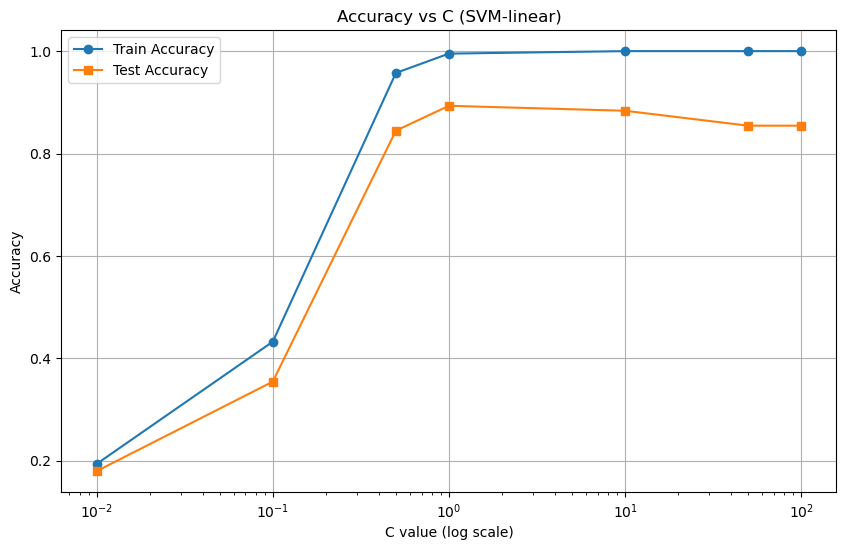

In [22]:
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score

# Danh sach gia tri C can khao sat:
C_values = [0.01, 0.1, 0.5, 1, 10, 50, 100]

# Lưu tru Accuracies
train_acc = []
test_acc = []

# Lap qua tung gia tri cua C
for c in C_values:
    model = svm.SVC(kernel='linear', C=c)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

# Ve bieu do
plt.figure(figsize=(10, 6))
plt.plot(C_values, train_acc, marker='o', label='Train Accuracy')
plt.plot(C_values, test_acc, marker='s', label='Test Accuracy')
plt.xscale('log')  
plt.xlabel('C value (log scale)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C (SVM-linear)')
plt.legend()
plt.grid(True)
plt.show()


Nhu vay C la tham so phat dieu chinh moi khi mo hinh sai Khi C nho -> Regularization manh  (Mo hinh don gian hon), Khi C lon -> mo hinh tro nen phuc tap hon
Khi C nho, do chinh xac cao, khi C lon, do chinh xac thap

#### Bài 5: Sử dụng GridSearchCV để tìm bộ tham số tốt nhất

In [23]:
# code
# Có thể tham khảo giá trị các tham số như sau
params_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
          'gamma': [0.0001, 0.001, 0.01, 0.1],
          'kernel':['linear','rbf', 'poly'] }


grid_sreach = GridSearchCV(svm.SVC(), params_grid, cv = 5, scoring='accuracy', verbose=1)
grid_sreach.fit(X_train, y_train)

print("Best parameters: ", grid_sreach.best_params_)
print("Best accyracy: ", grid_sreach.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters:  {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}
Best accyracy:  0.8574870657797486


### 4.2 Phân loại số viết tay 

In [24]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
target = digits.target
X_train, X_test, y_train, y_test = train_test_split( data, target, test_size=test_size)

print("Dữ liệu training = ", X_train.shape, y_train.shape)
print("Dữ liệu testing = ", X_test.shape, y_test.shape)


Dữ liệu training =  (1437, 64) (1437,)
Dữ liệu testing =  (360, 64) (360,)


#### Bài 6: phân loại với dữ liệu trên

In [25]:
##### exercise #####
# Yêu cầu: Ứng dụng mô hình svm vào bài toán phân loại ảnh 
# Gợi ý: dữ liệu đã được chia train, test, Áp dụng phần 2. và 3. để training và testing model. Chú ý nên có thêm phần tuning model
# model = None
######################

#Training SVM model
print("Training:")
cv_model = svm.SVC(kernel='linear', C = 1) ## Best model
cv_model.fit(X_train, y_train)
print("Model train complete!")


######################

Training:
Model train complete!


In [28]:
## Testing model:

y_cv_test_pred = cv_model.predict(X_test)
y_cv_train_pred = cv_model.predict(X_train)

print("- Test acc: {}".format(accuracy_score(y_test, y_cv_test_pred)))
print("- Train acc = {}".format(accuracy_score(y_train, y_cv_train_pred)))


- Test acc: 0.975
- Train acc = 1.0


In [27]:
## Turning model dung gridsreach nhu vua nay 
params_grid2 = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
          'gamma': [0.0001, 0.001, 0.01, 0.1],
          'kernel':['linear','rbf', 'poly'] }


grid_sreach2 = GridSearchCV(svm.SVC(), params_grid, cv = 5, scoring='accuracy', verbose=1)
grid_sreach2.fit(X_train, y_train)

print("Best parameters: ", grid_sreach.best_params_)
print("Best accyracy: ", grid_sreach.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters:  {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}
Best accyracy:  0.8574870657797486
